In [279]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

num_prediction = 120
look_back = 4 * 24
num_epochs = 5
seq_len = 18
batch_size=256
loss="mae"

In [280]:
# url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
# df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
# df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
# df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
# df.set_axis(df['date'], inplace=True)

# # df.drop(columns=["date"], inplace=True)
# df.info()

In [281]:
# url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
def getDataset():
    url = "./datasets/eurusd-m15-2018/EURUSD.csv"
    df = pd.read_csv(url)
    df.drop("Volume", 1, inplace=True)
    df["Date"] = df["Date"].astype(str) + " " + df["Timestamp"]
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index("Date", inplace=True)
    # df.drop("Date", 1, inplace=True)
    df.drop("Timestamp", 1, inplace=True)
    df.drop("Open", 1, inplace=True)
    df.drop("High", 1, inplace=True)
    df.drop("Low", 1, inplace=True)
    return df

df = getDataset()
df.head()
    

,Close
Date,
2015-01-25 22:00:00,1.11380
2015-01-25 22:15:00,1.11422
2015-01-25 22:30:00,1.11482
2015-01-25 22:45:00,1.11430
2015-01-25 23:00:00,1.11425


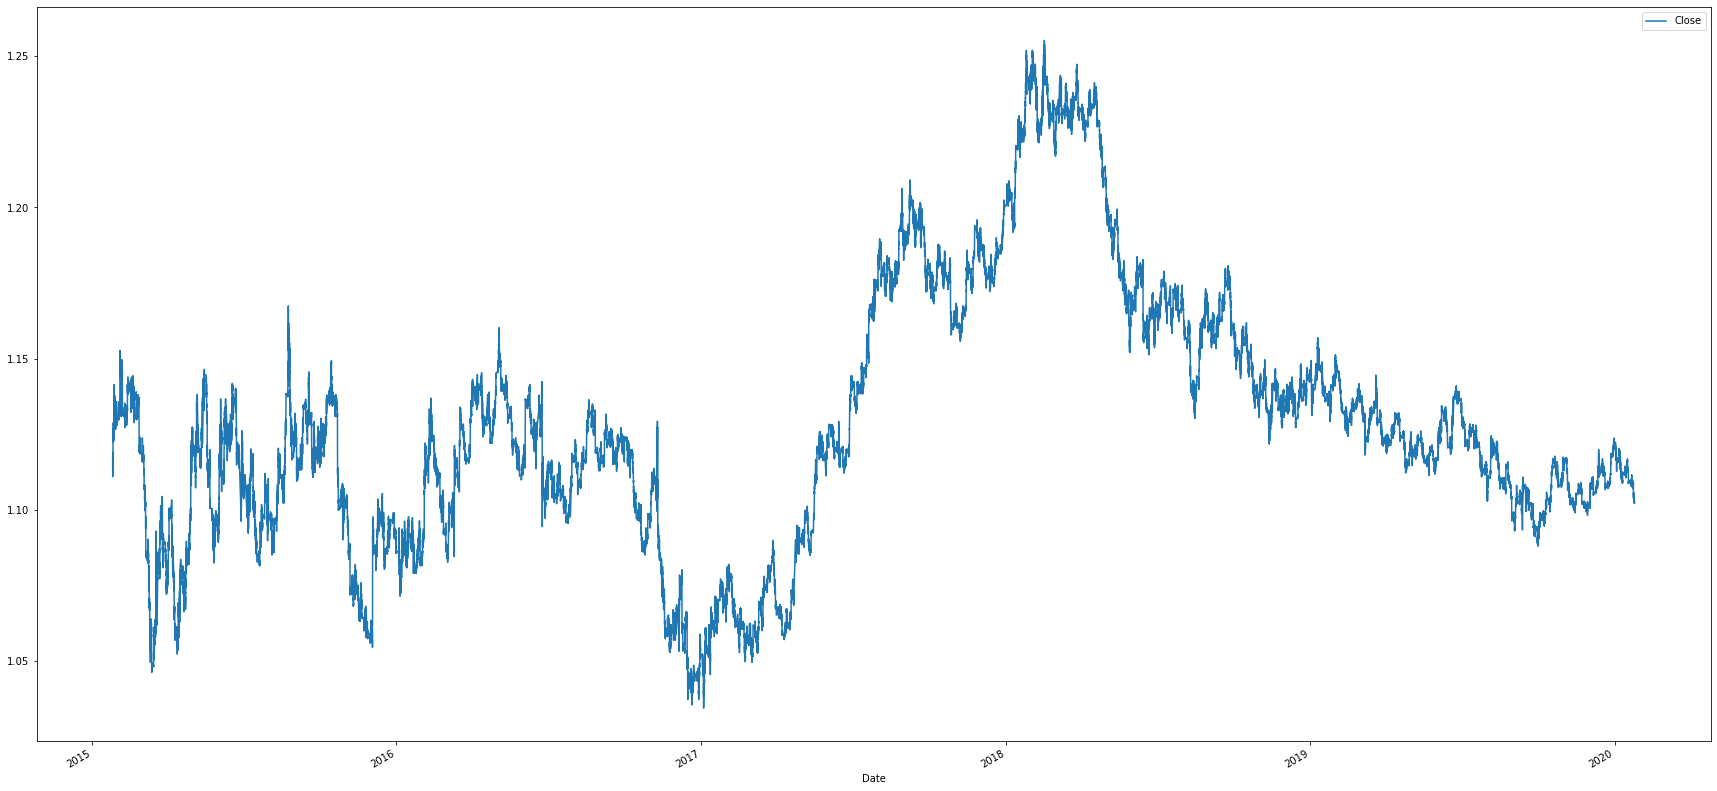

In [282]:
df.plot(figsize=(30,15))

In [283]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df.index[:split]
date_test = df.index[split:]

print(len(close_train))
print(len(close_test))

99715
24929


In [284]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

def getY(data):
    X_train = []
    y_train = []
    for i in range(look_back, len(data)-seq_len):
        X_train.append(data[i-look_back:i])
        y_train.append(data[i:i+seq_len])
    X_train, y_train = np.array(X_train), np.array(y_train)

    return X_train, y_train

x_train,y_train=getY(close_train)
x_test, y_test=getY(close_test)

print(y.shape)
print(x.shape)

(124536, 12, 1)
(124536, 96, 1)


In [285]:

x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped).reshape(-1, look_back, 1)
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped).reshape(-1, look_back, 1)

y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped).reshape(-1, seq_len, 1)
y_test_scaled = y_scaler.transform(y_test_reshaped).reshape(-1, seq_len, 1)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

validation_data = (x_test_scaled, y_test_scaled)

print(x_train_scaled.shape)               
print(y_train_scaled.shape)

Min: 0.0
Max: 1.0
(99601, 96, 1)
(99601, 18, 1)


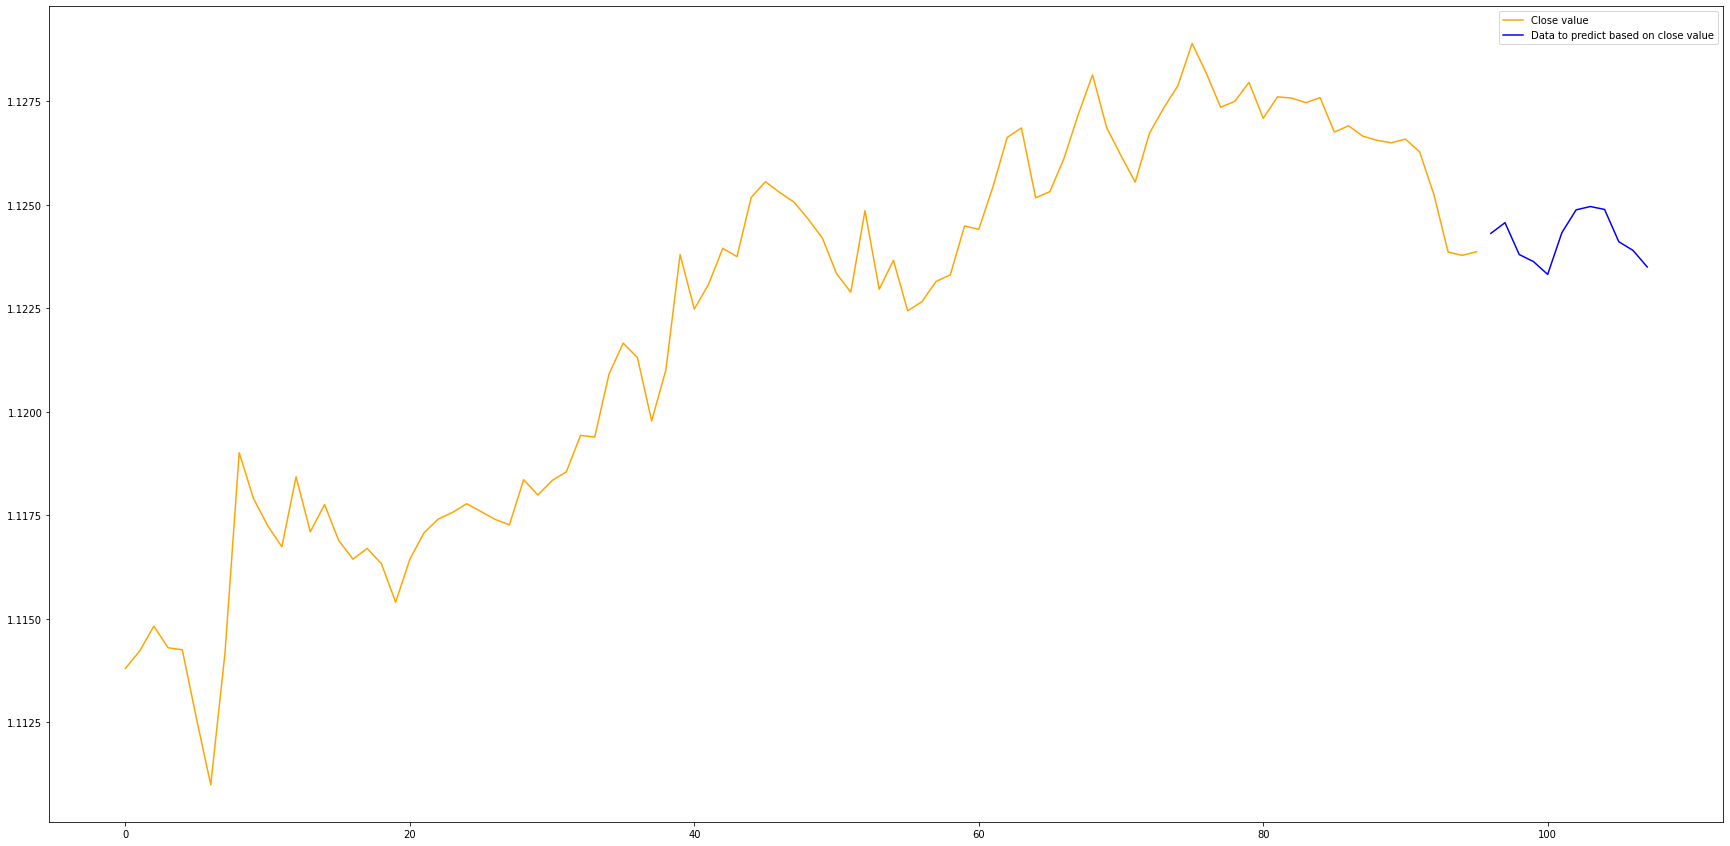

In [286]:
fig, ax = plt.subplots(figsize=(30,15))
ax.plot([i for i in range(0, x.shape[1])], x[0].reshape(1,-1)[0], label='Close value', color='orange')
ax.plot([i for i in range(x.shape[1], x.shape[1]+y.shape[1])],y[0].reshape(1,-1)[0], label='Data to predict based on close value', color = 'blue')
ax.legend()
plt.show()

In [287]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional

model = Sequential()

# model.add(Bidirectional(GRU(units=64, return_sequences=True),input_shape=(x_train_scaled.shape[1], 1)))
model.add(GRU(units=64,input_shape=(x_train_scaled.shape[1], 1)))
# model.add(GRU(64))
# model.add(Dense(units=seq_len+10, activation="relu"))
model.add(Dense(units=seq_len, activation="linear"))
model.compile(optimizer='rmsprop', loss=loss)

In [288]:
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 96, 64)            6720      
_________________________________________________________________
gru_12 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_16 (Dense)             (None, 28)                924       
_________________________________________________________________
dense_17 (Dense)             (None, 18)                522       
Total params: 17,574
Trainable params: 17,574
Non-trainable params: 0
_________________________________________________________________
None


In [289]:
history=model.fit(x_train_scaled, y_train_scaled, epochs=num_epochs, validation_data=(x_test_scaled, y_test_scaled), batch_size=batch_size, shuffle=True, verbose=1)

Epoch 1/5
390/390 [==============================] - 45s 115ms/step - loss: 0.0372 - val_loss: 0.0042
Epoch 2/5
390/390 [==============================] - 38s 98ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 3/5
390/390 [==============================] - 39s 101ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 4/5
390/390 [==============================] - 39s 100ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 5/5
390/390 [==============================] - 39s 101ms/step - loss: 0.0063 - val_loss: 0.0033


In [290]:
def plotHistory(history):
    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(history.history['loss'], label='loss (training data)')
    ax.plot(history.history['val_loss'], label='loss (validation data)')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    ax.legend(loc="upper left")
    plt.title(f"loss = {loss}")
    plt.show()

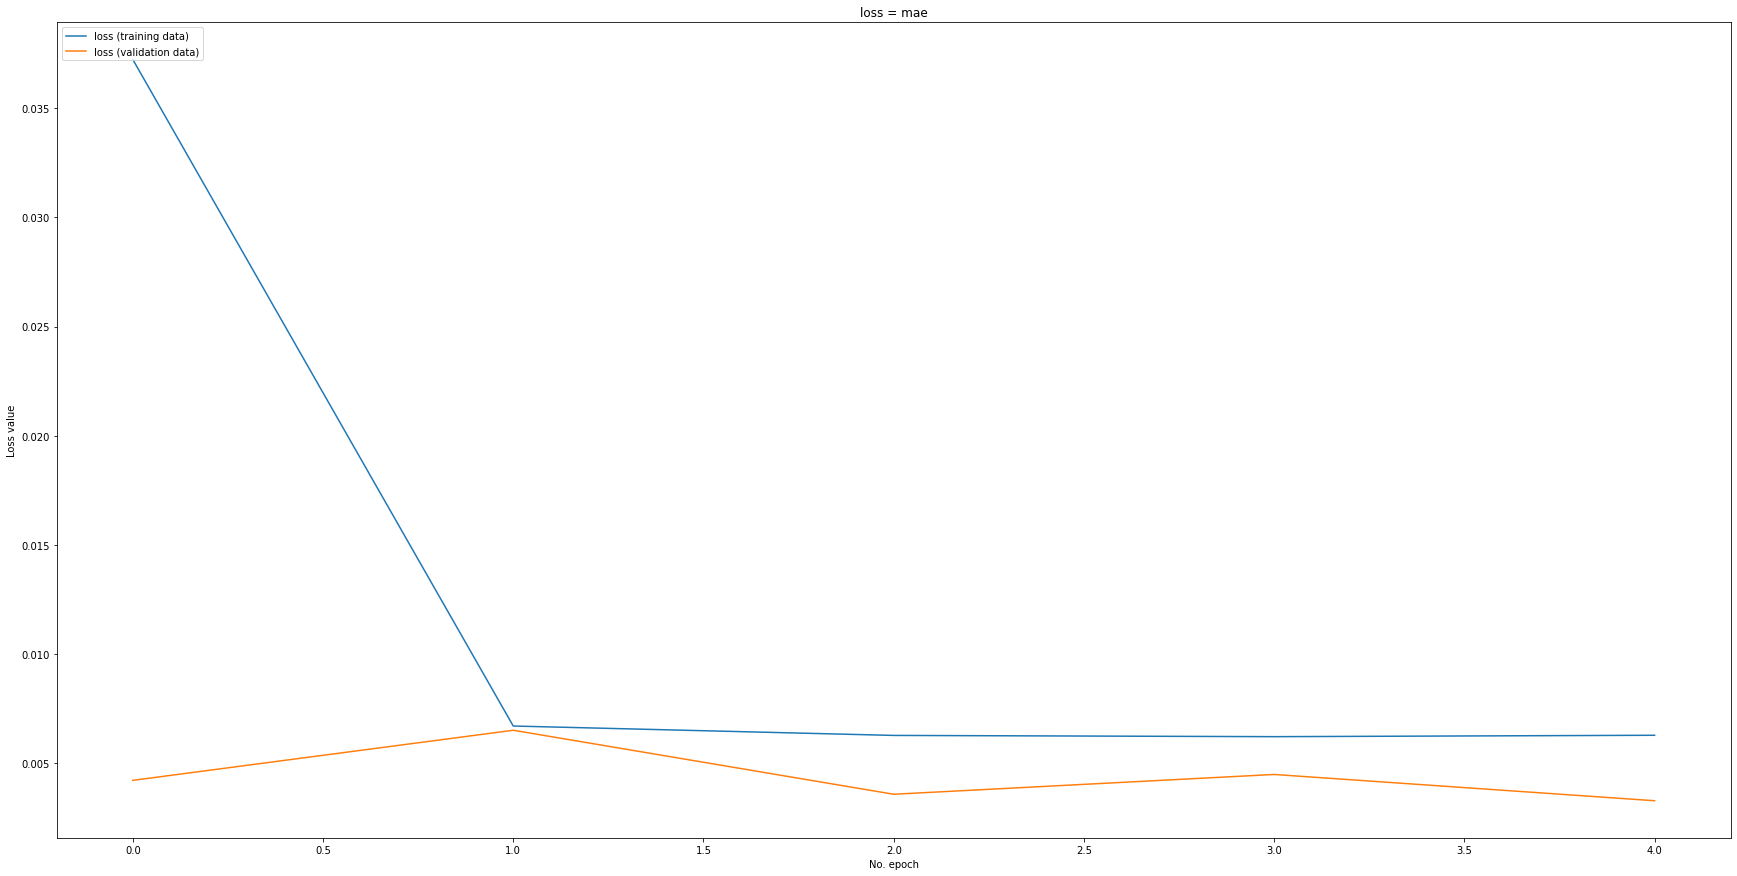

In [291]:
plotHistory(history)

In [292]:
def predictAndPlot(position=0, test=False, predictionPeriods=3):
    if test:
        x = x_test_scaled
    else:
        x = x_train_scaled

    prediction_list = np.array([x[position]])
    output=[]

    for i in range(predictionPeriods):
        y = model.predict(prediction_list).reshape(1,-1)[0]
        output.append(y)

        tmp = np.append(prediction_list[0].reshape(1,-1)[0],y)[-look_back:]
        predition_list = tmp.reshape(1, look_back, 1)

    pltx=x[position].reshape(1,-1)[0]
    plty=np.array(output).reshape(1,-1)[0]

    fig, ax = plt.subplots(figsize=(30,15))
    ax.plot(pltx, label='Base', color='orange')
    ax.plot([i for i in range(len(pltx), len(plty)+len(pltx))],plty, label='Data', color = 'blue')
    ax.plot([i for i in range(len(pltx), 2*len(pltx))], x[position+len(pltx)].reshape(1,-1)[0], label='Next base', color = 'green')
    # ax.plot(date_test[:minn], prediction[:minn], label="XD", color="green")
    # plt.xlabel('years')
    # plt.ylabel('prices')
    # plt.savefig(f"pngs/cf{}")
    plt.show() 

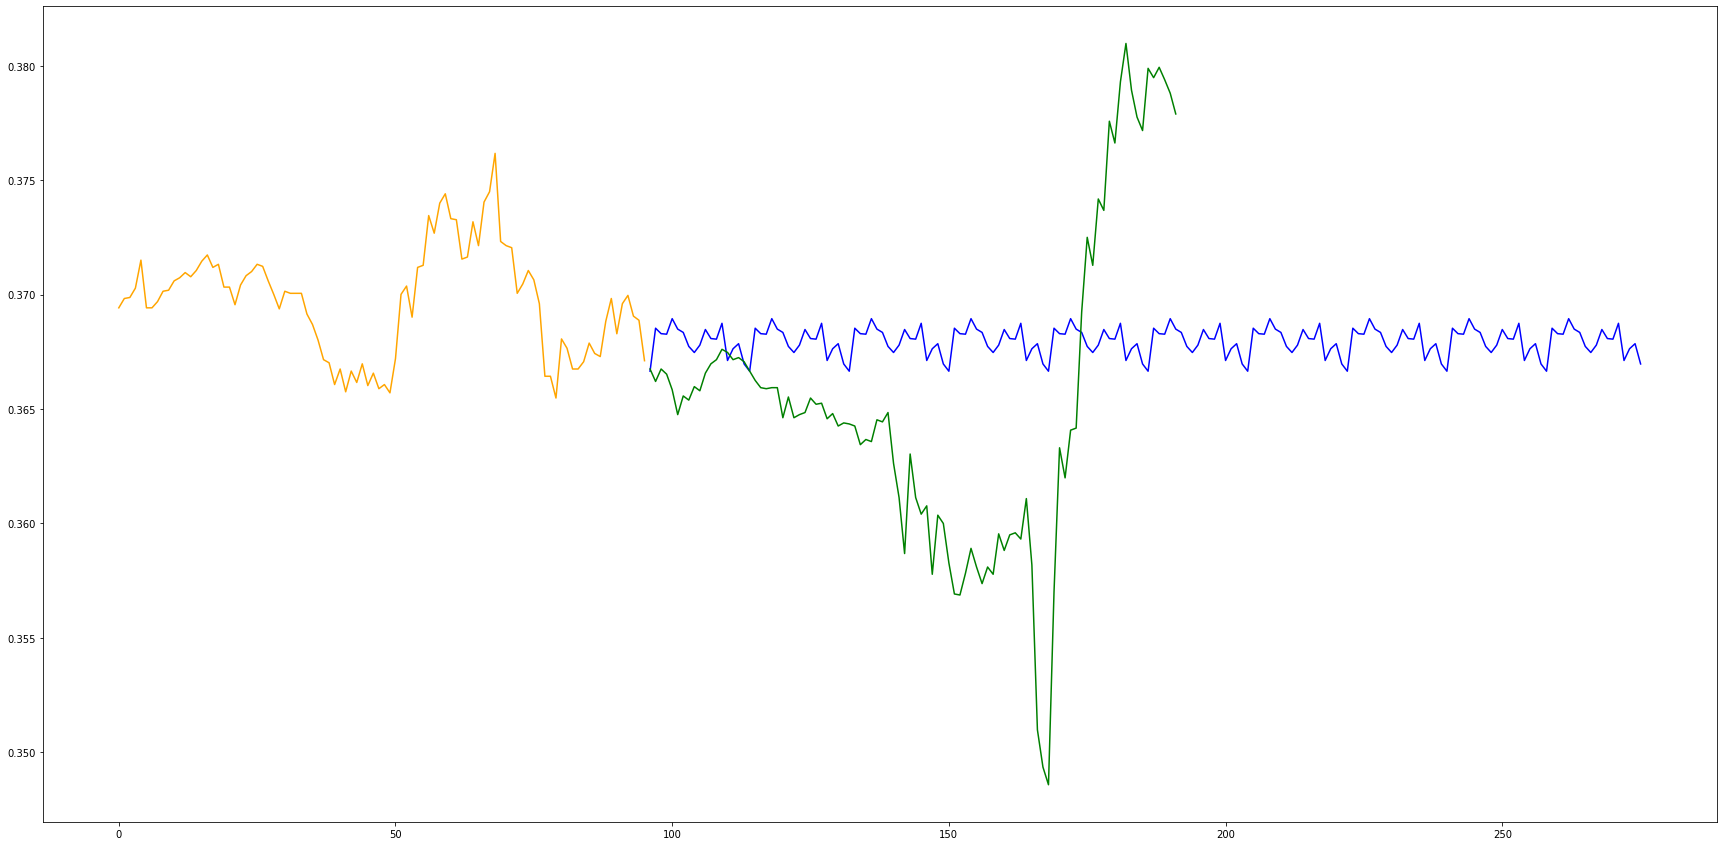

In [293]:
predictAndPlot(8000, True, 10)

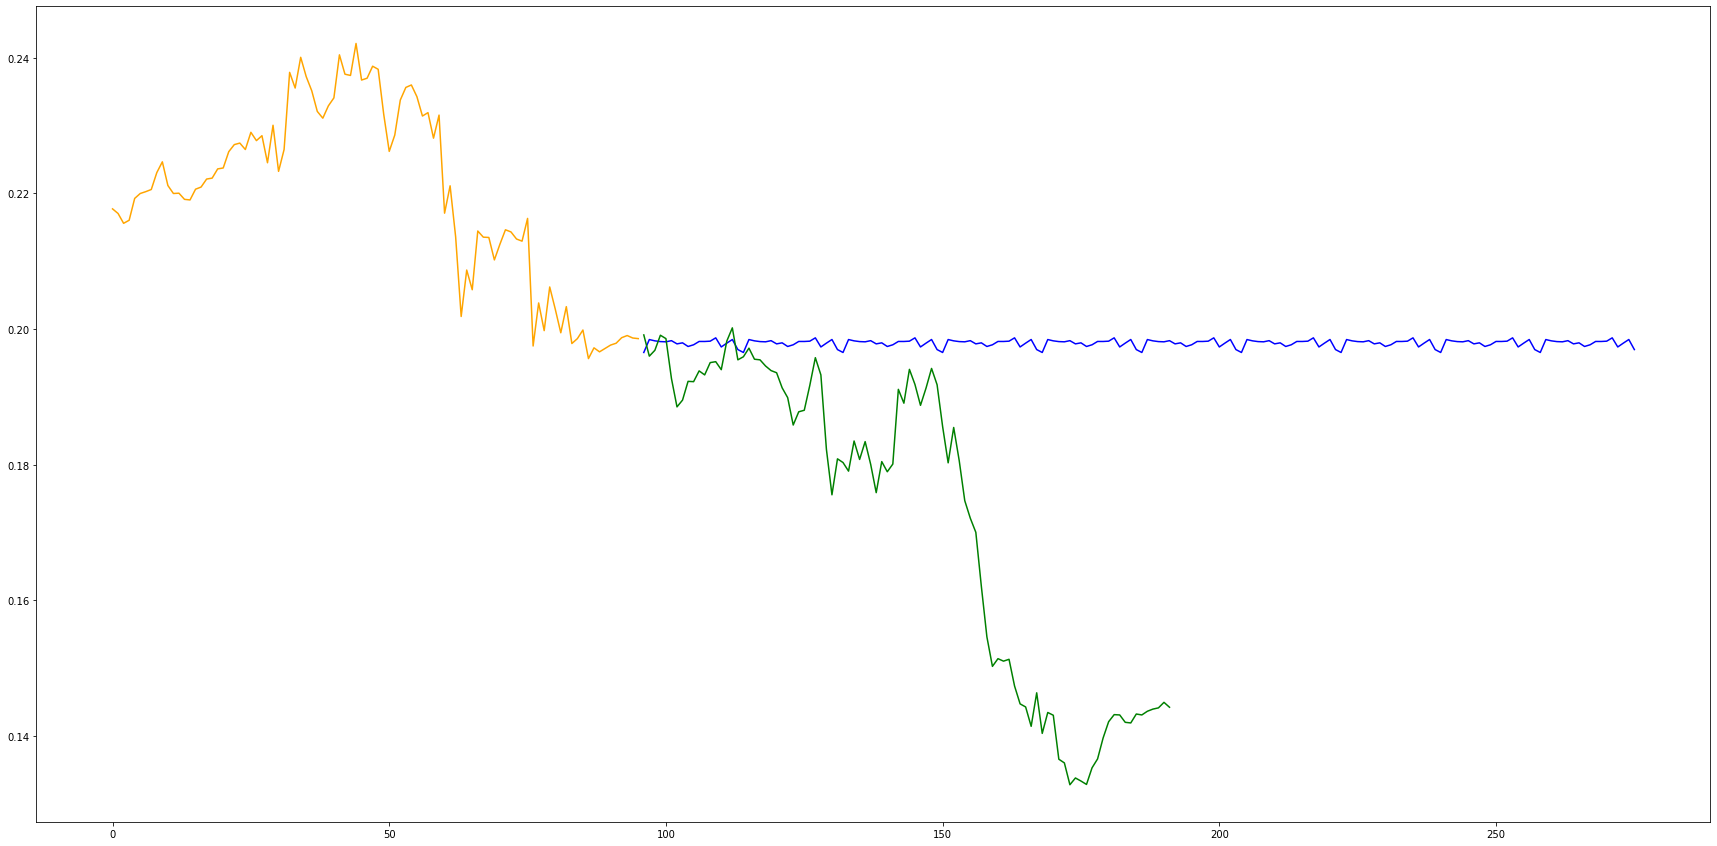

In [294]:
predictAndPlot(5000, False, 10)     

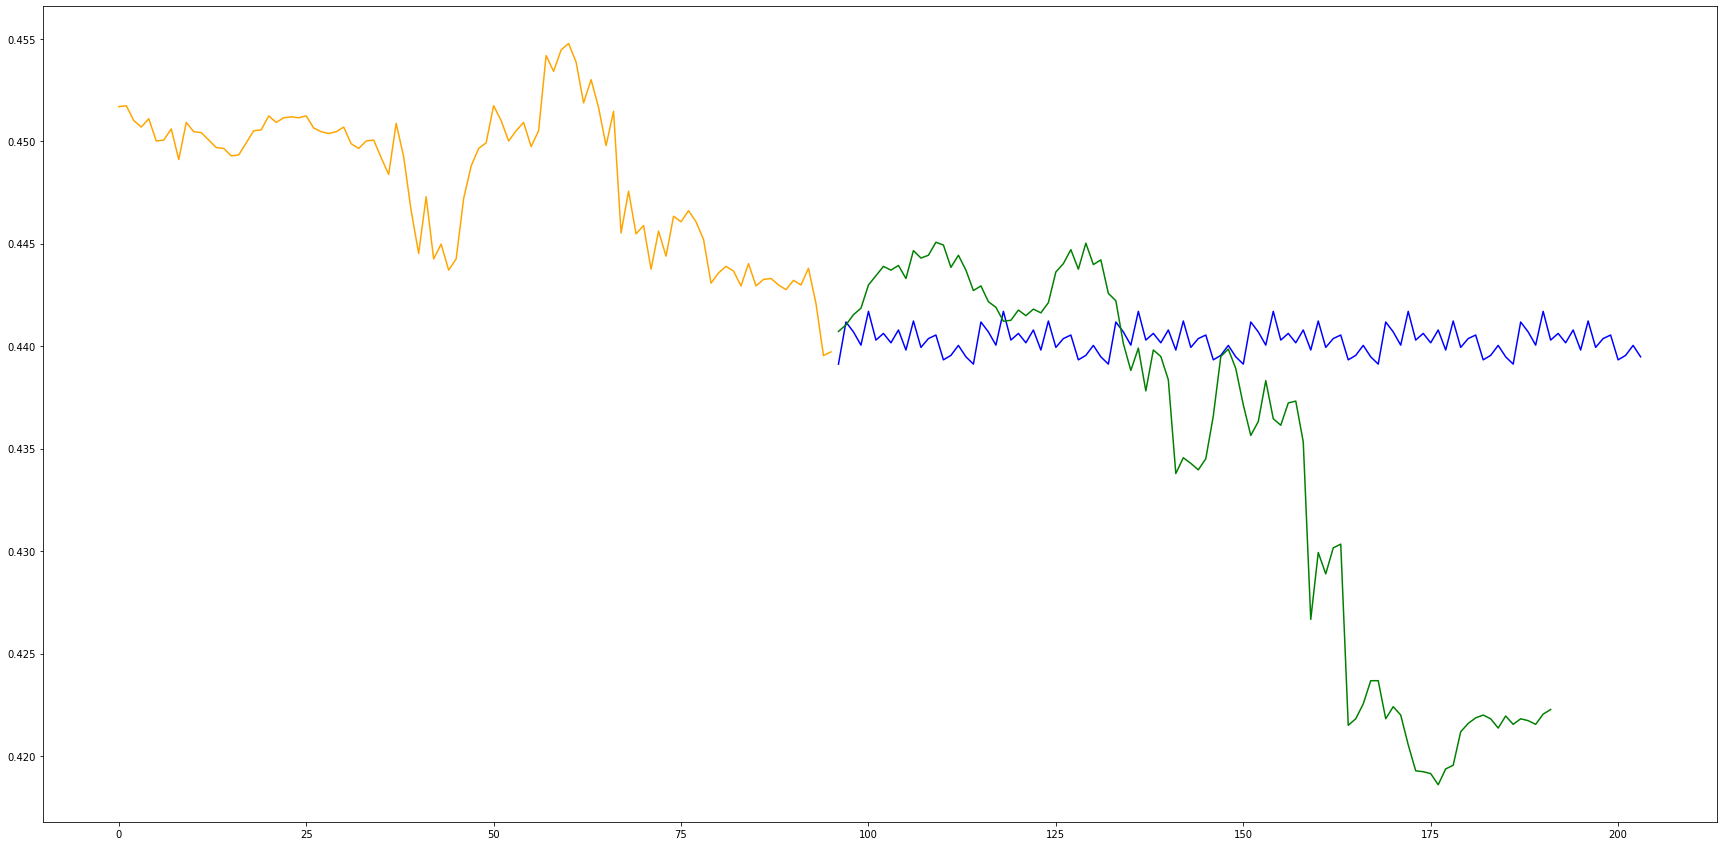

In [295]:
predictAndPlot(1000, True, 6)